## Graph model selection outputs

In [120]:
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

run = "base_strongaug_ema_inf_sq" #"base_strongaug_ema_inf_sq"
outputs_filename = f"/home/heather/GitHub/aldi0107/outputs/urchininf/{run}/model_selection/model_selection.json"
df = pd.read_json(outputs_filename)  # or however you load your DataFrame
# Create relplot
df['model_shortname'] = df['model'].apply(lambda x: x[-17:-4])
df['domain'] = df['source'].apply(lambda x: "source" if x else "target")
df['dataset_og'] = df['dataset'].apply(lambda x: x[4:-14])

df = df[df['model_shortname'] != "I/model_final"]


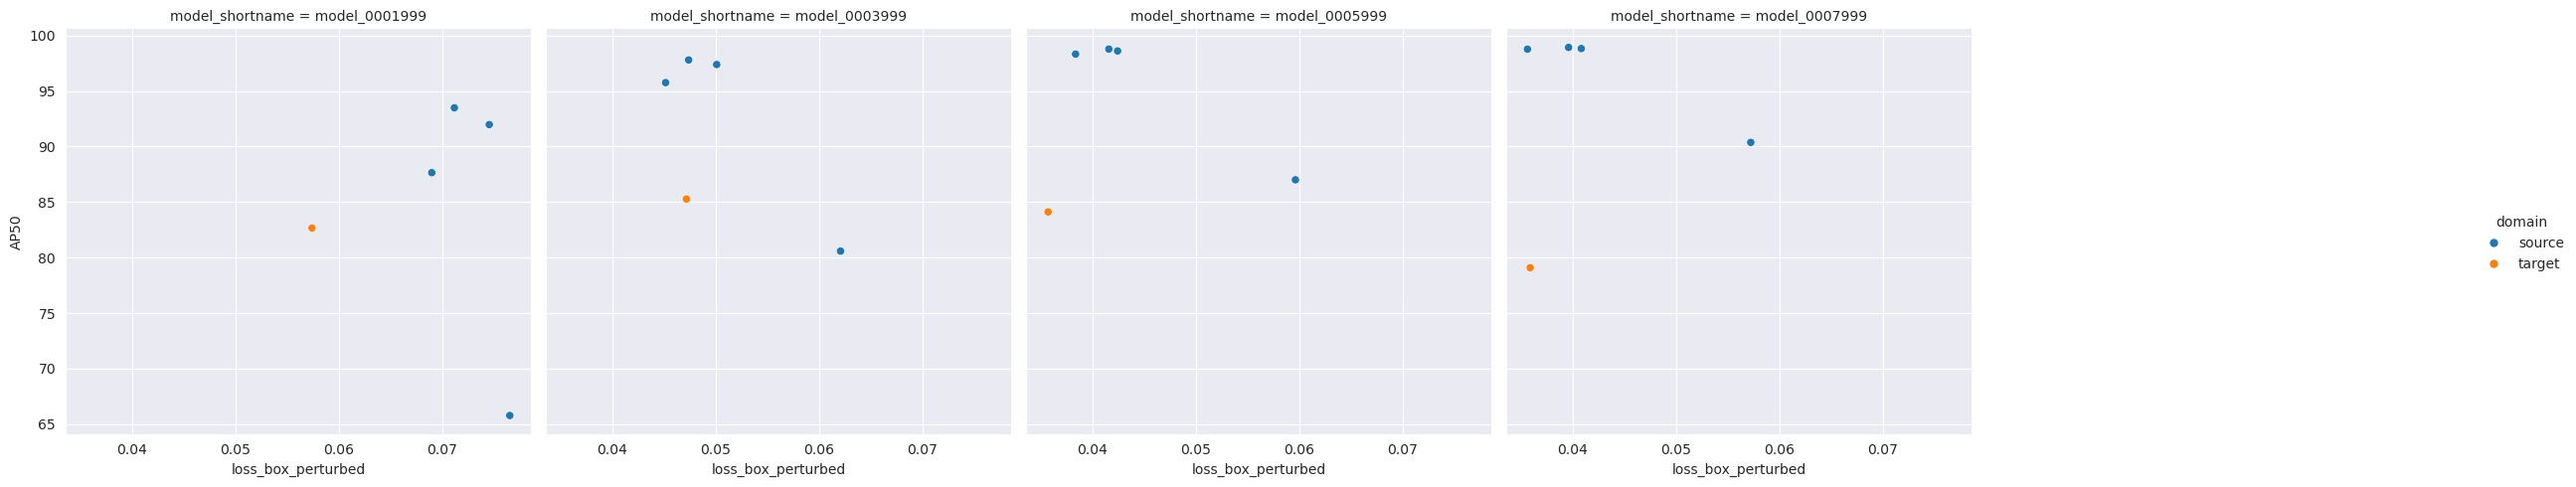

In [121]:


factor = 'loss_box_perturbed'
#factor = 'loss_cls_gt_boxes'
eval = 'AP50'
    
sns.relplot(data=df, x=factor, y=eval, hue='domain', col='model_shortname', kind='scatter', col_wrap=5)



# Show plot
plt.show()

In [122]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

eval_calc = f"{eval}_calc"
df[eval_calc] = 0.0
model_names = sorted(list(set(df['model_shortname'])))
for m in model_names:
    model = LinearRegression()
    model_src_data = df.loc[(df['model_shortname']==m) & df['source']]
    if len(model_src_data) > 0:
        model_tgt_data = df.loc[(df['model_shortname']==m) & (df['source']==False)]
        model.fit(model_src_data[[factor]], model_src_data[eval])
        out = list(model.predict(model_tgt_data[[factor]]))
        #print(f" out {out}")
        df.loc[(df['model_shortname']==m) & (df['source'] == False), eval_calc] = out
        mean_eval = df.loc[(df['model_shortname']==m) & (df['source'] == False)][[eval]].mean()[0]
        #print(df.loc[(df['model_shortname']==m) & (df['source'] == False)])
        mean_eval_calc = df.loc[(df['model_shortname']==m) & (df['source'] == False)][[eval_calc]].mean()[0]
        print(f"Actual {eval}: {mean_eval}, Predicted: {mean_eval_calc} Mean squared error: {mean_squared_error(out, model_tgt_data[[eval]]):.2f}")
        

Actual AP50: 82.6622100422, Predicted: 122.34282202978838 Mean squared error: 1574.55
Actual AP50: 85.2732298955, Predicted: 96.9976383699043 Mean squared error: 137.46
Actual AP50: 84.1154817789, Predicted: 101.46608833180576 Mean squared error: 301.04
Actual AP50: 79.087776991, Predicted: 99.92831559725781 Mean squared error: 434.33


/tmp/ipykernel_2552368/286697363.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_eval = df.loc[(df['model_shortname']==m) & (df['source'] == False)][[eval]].mean()[0]
/tmp/ipykernel_2552368/286697363.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_eval_calc = df.loc[(df['model_shortname']==m) & (df['source'] == False)][[eval_calc]].mean()[0]
/tmp/ipykernel_2552368/286697363.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

In [123]:
print(df.loc[(df['model_shortname']==m) & (df['domain'] == 'target')][eval_calc])

19    99.928316
Name: AP50_calc, dtype: float64


In [124]:
#sns.lmplot(data=df, x=factor, y=eval_calc, hue='domain', col='model_shortname')
results_df = df[['domain', eval, factor, 'model_shortname']].copy()
results_df['GT'] = 'Yes'

predict_df = df.loc[df['domain']=='target',['domain', eval_calc, factor, 'model_shortname']].copy()
predict_df['GT'] = 'No'
predict_df.columns = results_df.columns


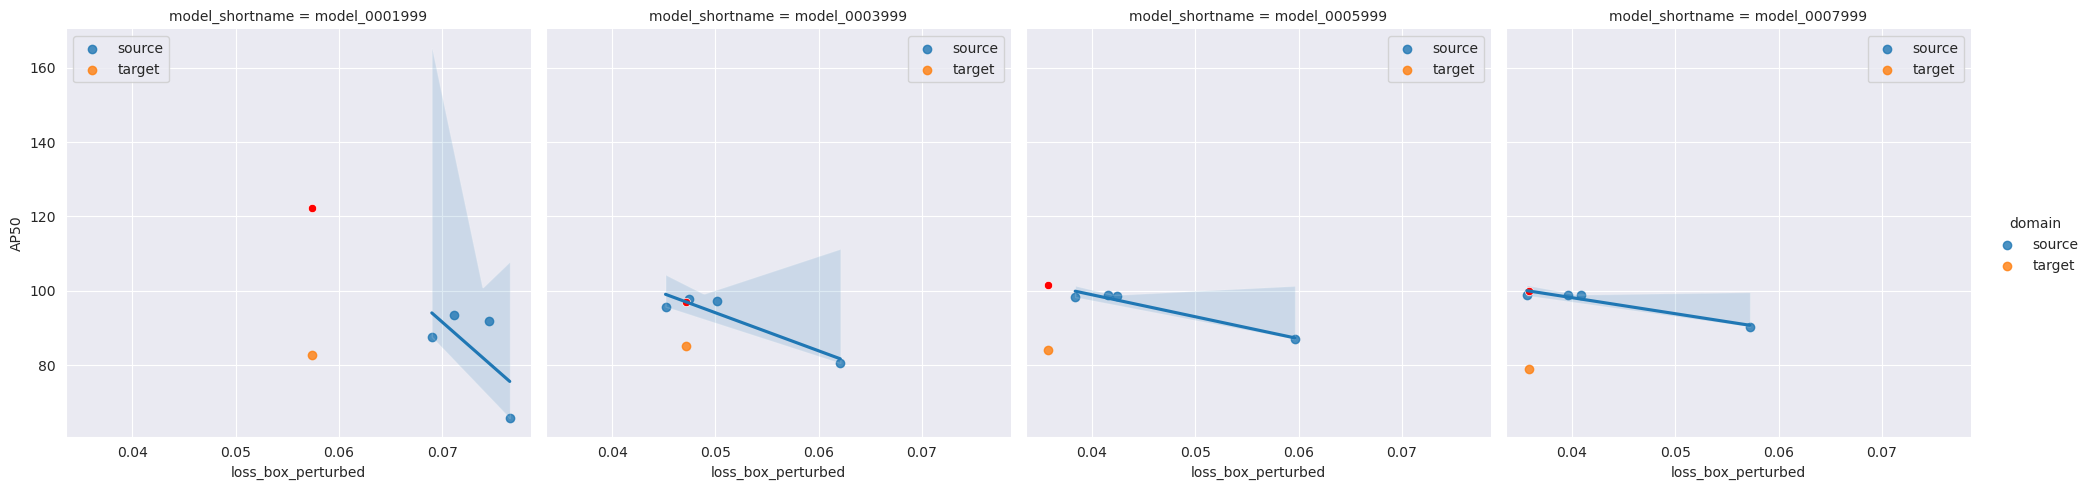

In [125]:
summary_df = pd.concat([results_df, predict_df], ignore_index=True)
# Create a FacetGrid
g = sns.lmplot(data=results_df, x=factor, y=eval, hue='domain', col='model_shortname', col_wrap=4)

# Add scatter plot and linear regression line to each facet
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the region
    mod_name = ax.get_title().split(' = ')[1]
    
    # select the data for the region
    data = predict_df[predict_df.model_shortname.eq(mod_name)]
    data = data[(data['domain']=='target') & (data['GT'] == 'No')]
    sns.scatterplot(data=data, x=factor, y=eval, ax=ax, color='red')
